<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/four_combinations%20for%20datacrunch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [122]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [123]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [124]:
# train = pd.concat([train, target], axis=1)

In [125]:
validation_data = train[13000: ]
train_data = train[:13000]

In [126]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

In [127]:
all_cols = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14']

In [128]:
validation_data.shape

(1687, 14)

In [129]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_data = pd.DataFrame(sc.fit_transform(train_data), columns=all_cols)
validation_data = pd.DataFrame(sc.transform(validation_data), columns=all_cols)

In [130]:
target[13000:]

,target_r,target_g,target_b
13000,0.25,0.25,0.25
13001,0.25,0.25,0.25
13002,0.00,0.00,0.00
13003,0.50,0.50,0.50
13004,0.25,0.50,0.50
...,...,...,...
14682,0.00,0.50,0.50
14683,0.00,0.50,0.50
14684,0.00,0.25,0.00
14685,0.00,0.50,0.50


In [133]:
train_data = pd.concat([train_data, target[:13000]], axis=1)
validation_data = pd.concat([validation_data, target[13000:].reset_index(drop=True)], axis=1)

# TRAINING

In [134]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
    return score

In [135]:
# train[:10][['Feature_1', 'target_r']]

In [136]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()   
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-3], sequences[end_ix-1, -3:]
        # print(seq_x)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [137]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)

In [138]:
train_data_arr.shape, validation_data_arr.shape

((13000, 17), (1687, 17))

In [139]:
%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [14]:
# np.random.seed(60)
# df = []
# for i in range(1,30):
#     n_steps = i
#     X_train, y_train = split_sequences(train_data_arr, n_steps)
#     X_val, y_val = split_sequences(validation_data_arr, n_steps)

#     n_input = X_train.shape[1] * X_train.shape[2]
#     X_train = X_train.reshape((X_train.shape[0], n_input))
#     X_val = X_val.reshape((X_val.shape[0], n_input))

#     from keras.models import Sequential
#     from keras.layers import Dense


#     model = Sequential()
#     model.add(Dense(1024, activation='sigmoid', input_dim=n_input))
#     model.add(Dense(512, activation='relu'))
#     # model.add(Dense(256, activation='relu'))
#     model.add(Dense(150, activation='relu'))
#     # model.add(Dense(50, activation='relu'))
#     model.add(Dense(3))
#     model.compile(optimizer='rmsprop', loss='mse')

#     early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
#     mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#     batch_size = 64
#     epochs = 250

#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=0, validation_data=(X_val, y_val), 
#                         callbacks=[early_stopping, mcp_save], shuffle=False)

    
#     # plot_metric(history, 'loss')
#     print( "TIME STEPS : --------> " , i)

#     model.load_weights('model.hdf5')
#     preds= model.predict(X_val, batch_size=batch_size)
#     cols = ['target_r', 'target_g', 'target_b']
#     preds = pd.DataFrame(preds, columns=cols)

#     scores = []
#     scores.append(n_steps)
#     scores.append(scorer(y_val[:, 0], preds.target_r))
#     scores.append(scorer(y_val[:, 1], preds.target_g))
#     scores.append(scorer(y_val[:, 2], preds.target_b))
#     df.append(pd.DataFrame(scores))

In [15]:
# df = pd.concat(df, axis=1)
# df.columns = df.iloc[0]
# df.drop(df.index[0], inplace=True)

In [16]:
# df.T

In [17]:
# df.T.max()

In [140]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [142]:
validation_data = train[13000: ]
train_data = train[:13000]

In [143]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_data = pd.DataFrame(sc.fit_transform(train_data), columns=all_cols)
validation_data = pd.DataFrame(sc.transform(validation_data), columns=all_cols)

In [145]:
test_merge = validation_data[1682:]

In [147]:
validation_data = validation_data[:1682]

In [152]:
validation_data.shape

(1682, 14)

In [153]:
train_data = pd.concat([train_data, target[:13000]], axis=1)
validation_data = pd.concat([validation_data, target[13000:14682].reset_index(drop=True)], axis=1)

In [154]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)
validation_data_arr.shape

(1682, 17)

Epoch 00028: early stopping


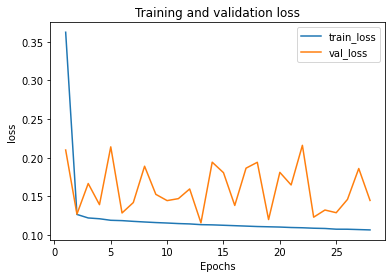

0.017702771307542678
0.12008677621704257
0.09373270886512512


In [155]:
np.random.seed(60)
n_steps = 6
X_train, y_train = split_sequences(train_data_arr, n_steps)
X_val, y_val = split_sequences(validation_data_arr, n_steps)

n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input))
X_val = X_val.reshape((X_val.shape[0], n_input))

from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(1024, activation='sigmoid', input_dim=n_input))
model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
model.add(Dense(150, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='rmsprop', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

batch_size = 64
epochs = 250

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=0, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, mcp_save], shuffle=True)


plot_metric(history, 'loss')

model.load_weights('model.hdf5')
preds= model.predict(X_val, batch_size=batch_size)
cols = ['target_r', 'target_g', 'target_b']
preds = pd.DataFrame(preds, columns=cols)

print(scorer(y_val[:, 0], preds.target_r))
print(scorer(y_val[:, 1], preds.target_g))
print(scorer(y_val[:, 2], preds.target_b))

In [156]:
test_data_with_lag = pd.concat([test_merge, test])
test_data_with_lag.shape

(14448, 14)

In [157]:
def split_sequences_for_prediction(sequences, n_steps):
    X= list()   
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
    # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x =sequences[i:end_ix]
        # print(seq_x)
        X.append(seq_x)
    return np.array(X)

In [158]:
preds_data = split_sequences_for_prediction(np.array(test_data_with_lag), 6)

In [159]:
preds_data.shape

(14443, 6, 14)

In [160]:
preds_data = preds_data.reshape((preds_data.shape[0], n_input))
preds_data.shape

(14443, 84)

In [161]:
prediction = pd.DataFrame(model.predict(preds_data, batch_size=batch_size))

In [162]:
prediction.columns = cols

In [164]:
prediction

,target_r,target_g,target_b
0,0.646894,0.682599,0.665862
1,0.576411,0.569824,0.599991
2,0.600224,0.647431,0.613021
3,0.538781,0.473264,0.406301
4,0.583156,0.551013,0.531323
...,...,...,...
14438,0.458901,0.427847,0.391024
14439,0.516775,0.474247,0.428844
14440,0.471891,0.430729,0.394004
14441,0.496247,0.463383,0.428657


# Other Models

In [176]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR, NuSVR

In [167]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)
train = pd.concat([train, target], axis=1)

In [267]:
corr = train[features].corrwith(train['target_g']).abs().sort_values(ascending=False)

In [268]:
corr

Feature_4     0.165860
Feature_14    0.132732
Feature_13    0.068288
Feature_11    0.058478
Feature_9     0.051720
Feature_12    0.049055
Feature_10    0.043745
Feature_1     0.040303
Feature_2     0.033834
Feature_6     0.032089
Feature_3     0.021898
Feature_7     0.017425
Feature_5     0.016203
Feature_8     0.009146
dtype: float64

In [269]:
four_combinations = []
from itertools import combinations, permutations, combinations_with_replacement
for i in combinations(corr.index.to_list(), 4):
    four_combinations.append(list(i))

In [270]:
len(four_combinations)

1001

In [271]:
four_combinations[0]

['Feature_4', 'Feature_14', 'Feature_13', 'Feature_11']

In [272]:
operators = ["+","-","*","/"]
op_list = []
for i in combinations_with_replacement(operators, 3):
    # print(i)
    op_list.append(list(i))

In [273]:
for_calc = []
for i in four_combinations[:1]:
    for x, y  in enumerate(op_list):
        f_calc = ("df['computed_" + str(x) + "'] =" + "train[a]" + y[0] + "train[b]" + y[1] + 
                  "train[c]" + y[2] + "train[d]" 
                #   + y[3] + "train[e]" + y[4] + "train[f]" + 
                #  y[5] + "train[g]" + y[6] + "train[h]" + y[7] + "train[i]" + y[8]+ "train[j]"
                 )
        for_calc.append(f_calc)

In [274]:
feature_names = []
for i in four_combinations:
    for x, y  in enumerate(op_list):
        f_name = (i[0] + y[0] + i[1] + y[1] + i[2] + y[2] + i[3] 
                #   + y[3] + i[4] + y[4] +
                #  i[5] + y[5] + i[6] + y[6] + i[7] + y[7] + i[8] + y[8] + i[9]
                )
        feature_names.append(f_name)
        

In [275]:
for i in for_calc:
    print(i)

df['computed_0'] =train[a]+train[b]+train[c]+train[d]
df['computed_1'] =train[a]+train[b]+train[c]-train[d]
df['computed_2'] =train[a]+train[b]+train[c]*train[d]
df['computed_3'] =train[a]+train[b]+train[c]/train[d]
df['computed_4'] =train[a]+train[b]-train[c]-train[d]
df['computed_5'] =train[a]+train[b]-train[c]*train[d]
df['computed_6'] =train[a]+train[b]-train[c]/train[d]
df['computed_7'] =train[a]+train[b]*train[c]*train[d]
df['computed_8'] =train[a]+train[b]*train[c]/train[d]
df['computed_9'] =train[a]+train[b]/train[c]/train[d]
df['computed_10'] =train[a]-train[b]-train[c]-train[d]
df['computed_11'] =train[a]-train[b]-train[c]*train[d]
df['computed_12'] =train[a]-train[b]-train[c]/train[d]
df['computed_13'] =train[a]-train[b]*train[c]*train[d]
df['computed_14'] =train[a]-train[b]*train[c]/train[d]
df['computed_15'] =train[a]-train[b]/train[c]/train[d]
df['computed_16'] =train[a]*train[b]*train[c]*train[d]
df['computed_17'] =train[a]*train[b]*train[c]/train[d]
df['computed_18'] =t

In [282]:
from google.colab import output
score = []
count = 0
df= pd.DataFrame()
for z in four_combinations:
    a = z[0]
    b = z[1]
    c = z[2]
    d = z[3]
    # e = z[4]
    # f = z[5]
    # g = z[6]
    # h = z[7]
    # i = z[8]
    # j = z[9]
    
    df['computed_0'] =train[a]+train[b]+train[c]+train[d]
    df['computed_1'] =train[a]+train[b]+train[c]-train[d]
    df['computed_2'] =train[a]+train[b]+train[c]*train[d]
    df['computed_3'] =train[a]+train[b]+train[c]/train[d]
    df['computed_4'] =train[a]+train[b]-train[c]-train[d]
    df['computed_5'] =train[a]+train[b]-train[c]*train[d]
    df['computed_6'] =train[a]+train[b]-train[c]/train[d]
    df['computed_7'] =train[a]+train[b]*train[c]*train[d]
    df['computed_8'] =train[a]+train[b]*train[c]/train[d]
    df['computed_9'] =train[a]+train[b]/train[c]/train[d]
    df['computed_10'] =train[a]-train[b]-train[c]-train[d]
    df['computed_11'] =train[a]-train[b]-train[c]*train[d]
    df['computed_12'] =train[a]-train[b]-train[c]/train[d]
    df['computed_13'] =train[a]-train[b]*train[c]*train[d]
    df['computed_14'] =train[a]-train[b]*train[c]/train[d]
    df['computed_15'] =train[a]-train[b]/train[c]/train[d]
    df['computed_16'] =train[a]*train[b]*train[c]*train[d]
    df['computed_17'] =train[a]*train[b]*train[c]/train[d]
    df['computed_18'] =train[a]*train[b]/train[c]/train[d]
    df['computed_19'] =train[a]/train[b]/train[c]/train[d]
    
    count += 1
    print("Done ", count , " out of ", len(four_combinations))
    if count % 10 == 0:
        output.clear()
    
    for i in df.corrwith(train['target_g']).abs().values:
        score.append(i)

Done  1001  out of  1001


In [283]:
results = pd.DataFrame(zip(feature_names, score), columns=['features', 'score']).sort_values(by='score',ascending=False)
results

,features,score
1205,Feature_4+Feature_14-Feature_3*Feature_7,0.216584
1225,Feature_4+Feature_14-Feature_3*Feature_5,0.214179
1081,Feature_4+Feature_14+Feature_2-Feature_5,0.212024
945,Feature_4+Feature_14-Feature_1*Feature_3,0.211845
345,Feature_4+Feature_14-Feature_11*Feature_3,0.211732
...,...,...
20014,Feature_3-Feature_7*Feature_5/Feature_8,NaN
20015,Feature_3-Feature_7/Feature_5/Feature_8,NaN
20017,Feature_3*Feature_7*Feature_5/Feature_8,NaN
20018,Feature_3*Feature_7/Feature_5/Feature_8,NaN


In [288]:
split = results[results['score'] > 0.21]['features'].to_list()

In [290]:
import re
feature_split = [] 
symbol_split = []
all_name = []
for i in split:
    all_name.append(i)
    features_list = re.split('[- + * /]',i)
    maths = re.findall(r"([\+\-\*\/]+)", i)
    feature_split.append(features_list)
    symbol_split.append(maths + [0])

In [298]:
count = 0
for i,j in zip(feature_split, symbol_split):
#     print([train.columns.get_loc(i[index]) for index in range(len(i))])
#     print(len(i))
    feature_name = all_name[count]
    print("df['"+feature_name+"']", "= " "df["+"'"+i[0]+"'"+"]", str(j[0]), "df["+"'"+i[1]+"'"+"]", str(j[1]), "df["+"'"+i[2]+"'"+"]" , str(j[2]), "df["+"'"+i[3]+"'"+"]"
    
    )
    count += 1

df['Feature_4+Feature_14-Feature_3*Feature_7'] = df['Feature_4'] + df['Feature_14'] - df['Feature_3'] * df['Feature_7']
df['Feature_4+Feature_14-Feature_3*Feature_5'] = df['Feature_4'] + df['Feature_14'] - df['Feature_3'] * df['Feature_5']
df['Feature_4+Feature_14+Feature_2-Feature_5'] = df['Feature_4'] + df['Feature_14'] + df['Feature_2'] - df['Feature_5']
df['Feature_4+Feature_14-Feature_1*Feature_3'] = df['Feature_4'] + df['Feature_14'] - df['Feature_1'] * df['Feature_3']
df['Feature_4+Feature_14-Feature_11*Feature_3'] = df['Feature_4'] + df['Feature_14'] - df['Feature_11'] * df['Feature_3']
df['Feature_4+Feature_14-Feature_2*Feature_3'] = df['Feature_4'] + df['Feature_14'] - df['Feature_2'] * df['Feature_3']
df['Feature_4+Feature_14-Feature_13*Feature_10'] = df['Feature_4'] + df['Feature_14'] - df['Feature_13'] * df['Feature_10']
df['Feature_4+Feature_14-Feature_13*Feature_11'] = df['Feature_4'] + df['Feature_14'] - df['Feature_13'] * df['Feature_11']
df['Feature_4+Feature_14-Featu

In [299]:
def additional_features(df):
    df['Feature_4+Feature_14-Feature_3*Feature_7'] = df['Feature_4'] + df['Feature_14'] - df['Feature_3'] * df['Feature_7']
    df['Feature_4+Feature_14-Feature_3*Feature_5'] = df['Feature_4'] + df['Feature_14'] - df['Feature_3'] * df['Feature_5']
    df['Feature_4+Feature_14+Feature_2-Feature_5'] = df['Feature_4'] + df['Feature_14'] + df['Feature_2'] - df['Feature_5']
    df['Feature_4+Feature_14-Feature_1*Feature_3'] = df['Feature_4'] + df['Feature_14'] - df['Feature_1'] * df['Feature_3']
    df['Feature_4+Feature_14-Feature_11*Feature_3'] = df['Feature_4'] + df['Feature_14'] - df['Feature_11'] * df['Feature_3']
    df['Feature_4+Feature_14-Feature_2*Feature_3'] = df['Feature_4'] + df['Feature_14'] - df['Feature_2'] * df['Feature_3']
    df['Feature_4+Feature_14-Feature_13*Feature_10'] = df['Feature_4'] + df['Feature_14'] - df['Feature_13'] * df['Feature_10']
    df['Feature_4+Feature_14-Feature_13*Feature_11'] = df['Feature_4'] + df['Feature_14'] - df['Feature_13'] * df['Feature_11']
    df['Feature_4+Feature_14-Feature_10*Feature_7'] = df['Feature_4'] + df['Feature_14'] - df['Feature_10'] * df['Feature_7']
    df['Feature_4+Feature_14-Feature_10*Feature_1'] = df['Feature_4'] + df['Feature_14'] - df['Feature_10'] * df['Feature_1']
    df['Feature_4+Feature_14-Feature_10*Feature_2'] = df['Feature_4'] + df['Feature_14'] - df['Feature_10'] * df['Feature_2']
    df['Feature_4+Feature_14-Feature_12*Feature_10'] = df['Feature_4'] + df['Feature_14'] - df['Feature_12'] * df['Feature_10']
    df['Feature_4+Feature_14-Feature_10*Feature_5'] = df['Feature_4'] + df['Feature_14'] - df['Feature_10'] * df['Feature_5']
    return df


In [301]:
train = additional_features(train)

In [227]:
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(train[features], train['target_r'], test_size=0.25, shuffle=False, random_state=60)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
model_b = AdaBoostRegressor(random_state=60, learning_rate=0.0001)
model_b.fit(X_train, y_train)
preds = model_b.predict(X_test)
scorer(preds, y_test)

0.10292780544119763

In [169]:
test = sc.transform(test)

In [170]:
prediction['target_b'] = model_b.predict(test)
prediction

,target_r,target_g,target_b
0,0.646894,0.682599,0.597933
1,0.576411,0.569824,0.432730
2,0.600224,0.647431,0.448555
3,0.538781,0.473264,0.432730
4,0.583156,0.551013,0.570312
...,...,...,...
14438,0.458901,0.427847,0.432730
14439,0.516775,0.474247,0.496716
14440,0.471891,0.430729,0.432730
14441,0.496247,0.463383,0.552260


In [171]:
prediction.describe()

,target_r,target_g,target_b
count,14443.000000,14443.000000,14443.000000
mean,0.495957,0.454951,0.475460
std,0.036694,0.037610,0.081547
min,0.318154,0.267882,0.262215
25%,0.476601,0.436153,0.432432
50%,0.500896,0.457928,0.432730
75%,0.520782,0.478341,0.545854
max,0.646894,0.682599,0.670515


# Predictions

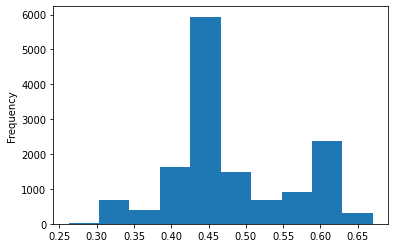

In [173]:
prediction['target_b'].plot(kind='hist')

In [174]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
